
<div align="center">

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dapivei/causal-infere/blob/main/sections/11_Instruments_RDD.ipynb)

</div>

# Instrumental Variables(Continued)

## Recap From Last Class
+ Instrumental Variables

## Goals For Today

1. Direct Effect and Connection to ITT
2. Weak Instruments
3. Instruments with Control
4. Collider Bias
5. Primer on Regression Discontinuity Design


## 2. Instrumental Variables (Continued)

Often, we cannot establish the following conditions to identify the causal parameter as (ubobserved) confounding can **bias** our estimates.

$$S \not\!\perp\!\!\!\perp U, \ \ S \not\!\perp\!\!\!\perp U \ | \ C$$

Instrumental variables is a specific setup to help identification even in the presence of *unobserved confounding* (when control/matching would not be able to identify).

<img src="https://raw.githubusercontent.com/dapivei/causal-infere/main/images/instrument.png" width="500"/>


For $Z$ to be a valid instrument, it must satisfy three important assumptions:

1.**Exogeneity**   2.**Relevance**   3.**Monotonicity**


Under our LATE assumptions, the Wald estimator identifies the LATE:

$$\alpha_{IV} = \frac{\text{Cov}(Z,Y)}{\text{Cov}(Z,S)} = \frac{\mathbb{E}[Y|Z =1]-\mathbb{E}[Y|Z =0]}{\mathbb{E}[S|Z =1]-\mathbb{E}[S|Z =0]}
=\mathbb{E}[Y(S =1,U)−Y(S =0,U)|Complier]= LATE$$

> Thus, **LATE** is the **difference in outcomes** between those who received the treatment and those who did not, **for the compliers**.


### Revisit - The effect of watching sesame street on later academic achievement.




> Does watching Sesame Street ($S$) have a positive impact on later academic achievement ($Y$)?

The dataset includes information on 240 children who were randomly assigned to two groups.

The treatment of interest here is **watching** Sesame Street.


***Model Setup***

\begin{aligned}
S & =\left\{\begin{array}{l}
1 \text { if watched Sesame }  \\
0 \text { did not watched Sesame}
\end{array}\right. \\
Z & =\left\{\begin{array}{l}
1 \text { if encouraged  }  \\
0 \text { not encouraged}
\end{array}\right. \\
S(Z, V) & =\text {If watched Sesame} \\
V & =\text { other determinants of } S \\
Y(S, U) & =\text {Score on a literacy test} \\
U & =\text { other determinants of } Y,
\end{aligned}

where $U$ and $V$ represents correspondingly other determinants of $Y$ and $S$ (e.g., socio-economic status).

The instrument $Z$ allows us to answer the following question:

> How does watching Sesame Street $S$ impact academic achievement $Y$ for children whose likelihood of watching the program is influenced by the encouragement $Z$?


### Data

- **`encour`**: Indicator variable for whether the child was encouraged to watch Sesame Stree. Instrument $Z$.
- **`watched`**: Indicator variable for whether the child actually watched Sesame Street. Treatment $S$.
- **`letters`**: Score on a literacy test. Outcome $Y$.
- **`age`**: Age of the child (in months), included as a control variable.
- **`female`**: Indicator variable for gender (female), included as a control variable.
- **`Other variables`**: Various additional factors.


In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np

from matplotlib.colors import LinearSegmentedColormap
from scipy import stats


sesame = pd.read_csv("../data/sesame.csv")
sesame.head()

,rownames,id,site,sex,age,viewcat,setting,viewenc,prebody,prelet,...,encour,_Isite_2,_Isite_3,_Isite_4,_Isite_5,regular,watched,encouraged,y,pretest
0,1,1,1,1,66,1,2,1,16,23,...,1,0,0,0,0,0,0,1,30,23
1,2,2,1,2,67,3,2,1,30,26,...,1,0,0,0,0,1,1,1,37,26
2,3,3,1,1,56,3,2,2,22,14,...,0,0,0,0,0,1,1,0,46,14
3,4,4,1,1,49,1,2,2,23,11,...,0,0,0,0,0,0,0,0,14,11
4,5,5,1,1,69,4,2,2,32,47,...,0,0,0,0,0,1,1,0,63,47


### "Reduced Form"

We can estimate the direct effect (ATE) of $Z$ on $Y$: how does the act of encouraging influence the later score performance?

This would be a valid causal estimate as the exogeneity assumption informs us of the independence assumption: $Z \perp U$.

In [2]:
smf.ols('y ~ encour', data=sesame).fit().summary() # you can also try robust sd

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.593
Date:                Sun, 22 Dec 2024   Prob (F-statistic):              0.109
Time:                        19:01:32   Log-Likelihood:                -961.16
No. Observations:                 240   AIC:                             1926.
Df Residuals:                     238   BIC:                             1933.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.9205      1.421     17.536      0.000      22.121      27.720
encour         2.8756      1.786      1.610      0.109      -0.642       6.393
==============================================================================
Omnibus:                       43.130   Durbin-Watson:                   1.269
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.314
Skew:                           0.535   Prob(JB):                     3.88e-05
Kurtosis:                       2.059   Cond. No.                         3.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The act of encouraging kids to watch Sesame Street has a nearly 3-point increase in their test scores! (though the p-value is not particularly small)

#### **Remember non-compliance and ITT?**

We can re-interpret this setup as the old ATE estimation problem. The treatment of interest, in this case, watching Sesame, cannot be enforced. We can randomize who are asked to watch Sesame Street, but there will be the non-compliance issue that prevents us from deriving ATE (given the always-takers and never-takers).

We have learned that we can change the causal question when there is non-compliance from ATE to Intent-to-Treat (ITT) effect.


The ITT estimates the causal effect of *treatment assignment* on the outcome of interest. Here, the ITT estimates the causal effect of being encouraged to watch Sesame Street on a child’s score on the literacy test.

Hence, the *treatment assignment* can also be framed as an instrumental variable. The direct effect we obtained above can also be thought of as being a ITT estimate.

### Weak Instrument

We have briefly covered testing assumptions from last week's lab.

For **exogeneity**, we can check for the distribution balance for some control variables across different values of instrument $Z$.

For **relevance**, in general, we can check the relationship between $S$ and $Z$. One approach is to look at the first-stage regression.

For **monotonicity**, this assumption is technically untestable. For example, we want to understand whether there are defilers or not in our data. However, we do not observe the counterfactual outcome for each individual (fundamental problem of causal inference). We can still reason about monotonicity based on previous evidence and assess whether this will likely be true for specific problem setup.

In particular, the ***weak instrument*** problem relates to the **relevance** assumption.

For the instrument to be relevant, it must be correlated with $S$ -- watching Sesame Street. Meaning that encouragement to watch Sesame Street has to actually make some kids more likely to watch it.

$$P(\text{Complier})>0 $$


We only require the proportion of compliers to be greater than $0$. This will still be true when the number is small or close to $0$, which gives us a weak instrument. It will blow up our estimator as the denominator of Cov$(S, Z)$ is small.

Similarly, we can test this with first-stage linear regression of the following form:
$$
S = \beta_0 + \beta_1 Z
$$
Once we fit the model, we can check for the F-statistic or t-statistic as we only have one independent variable in this regression.

In [3]:
smf.ols('watched ~ encour', data=sesame).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                watched   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     50.46
Date:                Sun, 22 Dec 2024   Prob (F-statistic):           1.40e-11
Time:                        19:01:32   Log-Likelihood:                -107.88
No. Observations:                 240   AIC:                             219.8
Df Residuals:                     238   BIC:                             226.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5455      0.041     13.434      0.000       0.465       0.625
encour         0.3624      0.051      7.104      0.000       0.262       0.463
==============================================================================
Omnibus:                       28.214   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.601
Skew:                          -0.943   Prob(JB):                     1.86e-08
Kurtosis:                       3.042   Cond. No.                         3.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The coefficient is 0.3624, meaning that being encouraged to watch Sesame Street increases the likelihood of watching the program by approximately 36.24% compared to those who were not encouraged.


The F-statistic is 50.46 which is more than the threshold 10 presented in the lecture.

Both p-values for the F/t-statistic are extremely small. Hence, we do not have a weak instrument problem here.



### Estimation


From last week, we saw that we can estimate using the covariance functions as well as running two-stage squares.

A more direct method is to call `IV2SLS` from `linearmodels` package.

- We would need to install it first in Colab.

#### Via the (explicit) Two-Stage Least Squares (2SLS) Estimation



1. **First stage**: Regress whether children watched Sesame Street $S$ on the instrument $Z$ (whether they were encouraged to watch).
2. **Second stage**: Regress the outcome (e.g., academic performance $Y$) on the predicted values of $S$ from the first stage.

This method isolates the causal effect of watching Sesame Street on the outcome for **compliers** (those who watched due to encouragement).



In [4]:
first_stage = smf.ols('watched ~ encour', data=sesame).fit()
sesame['predicted_watched'] = first_stage.fittedvalues
second_stage = smf.ols('y ~ predicted_watched', data=sesame).fit()
late_2sls_manual = second_stage.params['predicted_watched']
late_2sls_manual

np.float64(7.933993399339921)

For those children who are encouraged to watch Sesame Street and actually end up watching it, their academic achievement (e.g., literacy scores) increases by 7.94 units on average.

#### Via the IV2SLS Function from linearmodels

In [5]:
!pip install linearmodels

In [6]:
import linearmodels as lm

lm.IV2SLS.from_formula('y ~ 1 + [watched ~ encour]', data=sesame).fit().summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      y   R-squared:                      0.1355
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1318
No. Observations:                 240   F-statistic:                    2.9570
Date:                Sun, Dec 22 2024   P-value (F-stat)                0.0855
Time:                        19:01:34   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      20.593     3.6811     5.5942     0.0000      13.378      27.808
watched        7.9340     4.6138     1.7196     0.0855     -1.1090      16.977
==============================================================================

Endogenous: watched
Instruments: encour
Robust Covariance (Heteroskedastic)
Debiased: False
"""

### Instrument with Control

If we have extra observed characteristics, we can control them as part of the IV procedure.

This could potentially make the exogeneity argument stronger via conditional independence.

$$
Z \perp U | C
$$

However, this will impact the parameter estimate as we saw in regression with control. The weights for each controlled subgroup will change to the covariance of $Z$ and $S$ in that group.

$$
\alpha_1^{\text{IV, Cont.}} = E \left[ \frac{\text{Cov}(Z, S | C = c)}{\text{Cov}(Z, S)} \text{LATE}(C = c) \right]
$$

Let's try controlling for two variables `age` and `sex`.


In [7]:
first_stage = smf.ols('watched ~ encour + age + sex', data=sesame).fit()
sesame['predicted_watched'] = first_stage.fittedvalues
second_stage = smf.ols('y ~ predicted_watched + age + sex', data=sesame).fit()
late_2sls_manual = second_stage.params['predicted_watched']
late_2sls_manual

np.float64(8.482026098072684)

In [8]:
# direct method
lm.IV2SLS.from_formula('y ~ 1 + age + sex + [watched ~ encour]', data=sesame).fit().summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      y   R-squared:                      0.2077
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1976
No. Observations:                 240   F-statistic:                    25.201
Date:                Sun, Dec 22 2024   P-value (F-stat)                0.0000
Time:                        19:01:34   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -10.571     7.6520    -1.3814     0.1671     -25.568      4.4270
age            0.5505     0.1190     4.6241     0.0000      0.3172      0.7838
sex            1.5620     1.5530     1.0058     0.3145     -1.4818      4.6058
watched        8.4820     4.3245     1.9614     0.0498      0.0062      16.958
==============================================================================

Endogenous: watched
Instruments: encour
Robust Covariance (Heteroskedastic)
Debiased: False
"""

Our estimate is now 8.48 points. Nevertheless, in this **experiment**, we know beforehand that the instrument $Z$ was randomly assigned.

## 3. Colider Bias

Besides complicated interpretations, controlling for more variables can also get us in trouble due to colider bias.

In previous labs, we covered a brief overview of different types of conditional independence structures.


![Indep](https://catalogofbias.org/wp-content/uploads/sites/2/2019/03/Collider-bias_fig-1-e1551439537528.png)

**Collider bias** occurs when two variables independently influence a third variable (called a collider), and we condition on or control for this collider (or its descedents).

This conditioning can induce a spurious association between the two independent variables, leading to incorrect conclusions about their relationship. What are some real-life examples?

In [9]:
np.random.seed(42)  # For reproducibility

N = 10000  # Sample size
S = np.random.normal(0, 1, N)
Y = np.random.normal(0, 1, N)

noise = np.random.normal(0, 1, N)
C = 2 * S + 2 * Y + noise

data = pd.DataFrame({'S': S, 'Y': Y, 'C': C})

For simplicity, we will not introduce any dependence between $S$ and $Y$ to demonstrate how conditioning on $C$ creates dependence from 0.

In practice, $S$ does influence $Y$ directly, which is the direct causal effect of interest. Conditioning on $C$ will bias the effect with extra dependence.

In [10]:
corr_full = data['S'].corr(data['Y'])
print(f"Correlation between S and Y in the full dataset: {corr_full:.4f}")

Correlation between S and Y in the full dataset: -0.0086


In [11]:
threshold = np.percentile(data['C'], 90)
data_conditioned = data[data['C'] > threshold]

corr_conditioned = data_conditioned['S'].corr(data_conditioned['Y'])
print(f"Correlation between S and Y after conditioning on C: {corr_conditioned:.4f}")

Correlation between S and Y after conditioning on C: -0.6000


This negative correlation indicates that X and Y are now dependent after conditioning on Z, demonstrating collider bias.

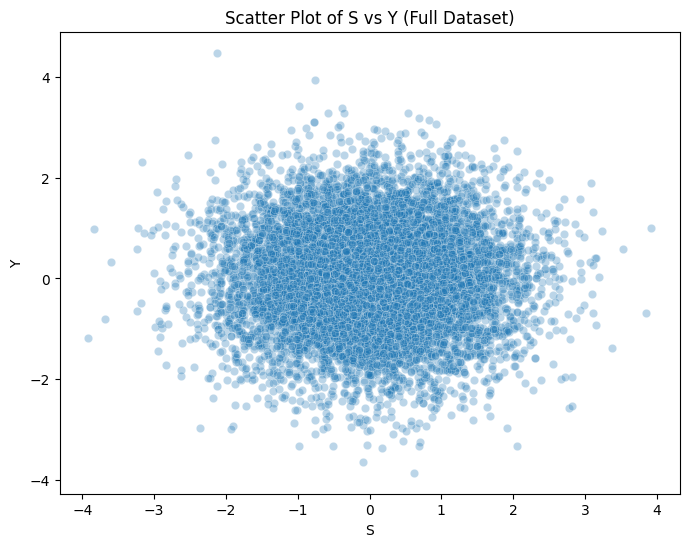

In [12]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='S', y='Y', data=data, alpha=0.3)
plt.title('Scatter Plot of S vs Y (Full Dataset)')
plt.show()

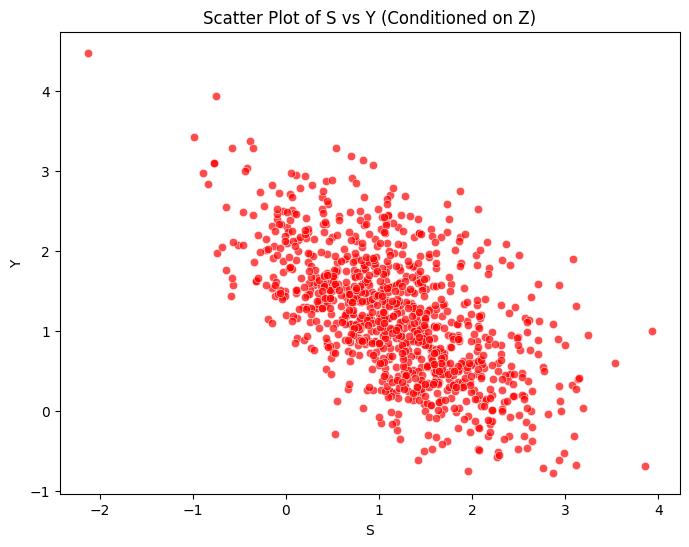

In [13]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='S', y='Y', data=data_conditioned, color='red', alpha=0.7)
plt.title('Scatter Plot of S vs Y (Conditioned on Z)')
plt.show()

We should be careful about which variables to control and reason about them based on the problem context to avoid additional bias.

## 4. Introduction to Regression Discontinuity

Most things in nature are continuous. If we see spikes or jumps, they are very likely to be **artificial**.

How can we leverage this phenomenon to derive valid causal estimates?

We will need to rely on some continuous variables $R$ that defines the treatment/control group via thresholds $c$ of $R$.

$$
S =
\begin{cases}
1 & \text{if } R \geq c \\
0 & \text{if } R < c
\end{cases}
$$

The core intuition for the validity of this method is that people near/around this cutoff $c$ should be randomly placed into treatment vs. control.

For example, there is no systematic reason for why someone got 91 on a test vs. someone got 89 except for some random chance.

Therefore, similar to LATE, the causal estimate from RDD can only be applied to the subgroup around cutoffs instead of the general population.






<img src="https://raw.githubusercontent.com/dapivei/causal-infere/a5e0159feda3746ba84a5e9bfec4e2a890685eb4/images/rdd.png" width="600">

#### Major Assumption

To estimate the differences, we require the expected potential outcomes is a ***continuous*** function of the running variable at the cutoff $c$ (smoothness assumption).

$$
\begin{align*}
    \mathbb{E}[Y | R = c] &= \mathbb{E}[Y(S = 1, U) | R = c] \quad & (r \geq c \Rightarrow S = 1) \\
    \lim_{r \uparrow c} \mathbb{E}[Y | R = r] &= \lim_{r \uparrow c} \mathbb{E}[Y(S = 0, U) | R = r] \quad & (r < c \Rightarrow S = 0) \\
    &= \mathbb{E}[Y(S = 0, U) | R = c] \quad & (\text{smoothness})
\end{align*}
$$

Practically, we need to select a bandwidth parameter $b$ to allow more samples around the cutoff point. This introduces a bias/variance tradeoff based on the magnitude of the bandwidth.

We can also simply check for multiple options of $b$ for robustness.

#### Estimation

We can estimate the difference in the above potential outcomes by selecting a bandwidth and using local linear regression:

$$
Y = \alpha_0 + \alpha_1 S + \alpha_2 (R - c) + \alpha_3 S \cdot (R - c) + \epsilon
$$

Under the smoothness assumption and "small enough" bandwidth, we can identify the causal parameter through $\alpha_1$:

$$
\alpha_1 = \mathbb{E}[Y(S = 1, U) -  Y(S = 0, U)| R = c]
$$

The centering allows the intercept terms to become the corresponding differences at $R=c$, and the interaction term allows different slopes for the two potential outcome functions.

In [14]:
np.random.seed(42)
n = 200
running_var = np.random.uniform(80, 100, n)
treatment = (running_var >= 90).astype(int)
noise = np.random.normal(0, 2, n)
outcome = 20 + 5 * treatment + 0.5 * (running_var - 90) + noise

data = pd.DataFrame({
    'running_var': running_var,
    'treatment': treatment,
    'outcome': outcome
})

We can plot our data and check for the jump around cutoff.

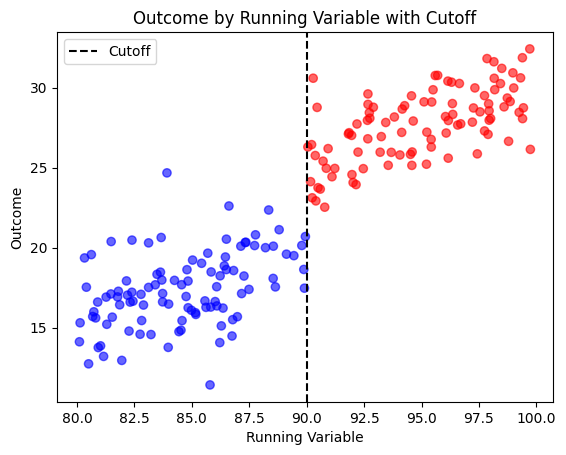

In [15]:
plt.scatter(data['running_var'], data['outcome'], c=data['treatment'], cmap='bwr', alpha=0.6)
plt.axvline(x=90, color='black', linestyle='--', label='Cutoff')
plt.xlabel("Running Variable")
plt.ylabel("Outcome")
plt.title("Outcome by Running Variable with Cutoff")
plt.legend()
plt.show()

In [16]:
def run_local_regression(data, bandwidth):
    subset = data[(data['running_var'] >= 90 - bandwidth) & (data['running_var'] <= 90 + bandwidth)].copy()
    subset['running_var_centered'] = subset['running_var'] - 90
    subset['treatment:running_var_centered'] = subset['treatment'] * subset['running_var_centered']
    model = smf.ols('outcome ~ treatment + running_var_centered + treatment:running_var_centered', data=subset)
    results = model.fit()
    return results

# example with bandwidth of 2
bandwidth = 2
results = run_local_regression(data, bandwidth)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     24.49
Date:                Sun, 22 Dec 2024   Prob (F-statistic):           5.54e-08
Time:                        19:01:34   Log-Likelihood:                -63.622
No. Observations:                  32   AIC:                             135.2
Df Residuals:                      28   BIC:                             141.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

We can check for the parameter estimates under different bandwidths.

In [17]:
for bw in [1, 5, 10]:
    print(f"\nResults for Bandwidth = {bw}")
    results = run_local_regression(data, bw)
    print(results.summary())


Results for Bandwidth = 1
                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     11.37
Date:                Sun, 22 Dec 2024   Prob (F-statistic):           0.000305
Time:                        19:01:34   Log-Likelihood:                -41.162
No. Observations:                  20   AIC:                             90.32
Df Residuals:                      16   BIC:                             94.31
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

Below is a simple visual check on if there is manipulation of groups around the cutoff point

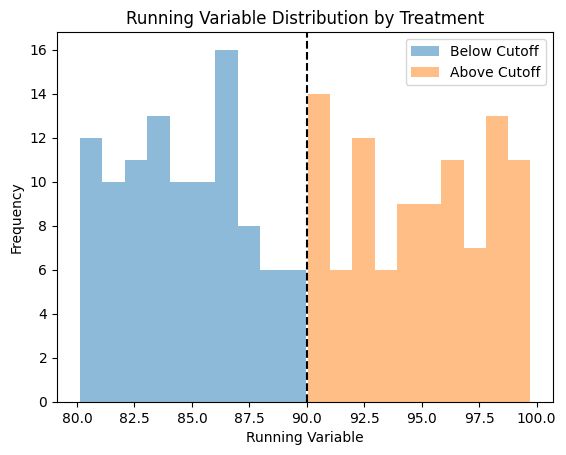

In [18]:
plt.hist(data['running_var'][data['treatment'] == 0], alpha=0.5, label='Below Cutoff')
plt.hist(data['running_var'][data['treatment'] == 1], alpha=0.5, label='Above Cutoff')
plt.axvline(x=90, color='black', linestyle='--')
plt.legend()
plt.xlabel("Running Variable")
plt.ylabel("Frequency")
plt.title("Running Variable Distribution by Treatment")
plt.show()

## Path Forward




- More on Regression Discontinuity